# Neural network tryouts to produce a image channel's formula learning

In [3]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

## Let's simulate data such that a sort of NDVI index segments good objects

Let input image have 4 channels, e.g. R,G,B,NIR. Each channel is normalized between [0, 1]. We fill all channels with random uniform noise. However, in R channel pixels of interest will have smaller than average noise values (absorption) and in NIR channel they will have larger than average noise values (emission). 

A NDVI-like image is composed as `(NIR - R) / (NIR + R)`. A binary mask of this NDVI-like image will serve as target image.

In [59]:
n_images = 500
input_height = 40
input_width = 40

inputs = np.random.rand(n_images,4,input_height, input_width) * 0.6 + 0.2
targets = np.zeros((n_images,1,input_height, input_width), dtype=np.uint8)
mean = 0.5

max_size = 7
objects = []

for i in range(n_images):
    
    xs = np.random.randint(1, input_width-max_size)
    xe = xs + np.random.randint(5, max_size)
    ys = np.random.randint(1, input_height-max_size)
    ye = ys + np.random.randint(5, max_size)
    
    objects.append((xs, ys, xe, ye))
    
    inputs[i, 0, ys:ye, xs:xe] = np.clip(inputs[i, 0, ys:ye, xs:xe] - 0.55*mean, 0, 1)
    inputs[i, 3, ys:ye, xs:xe] = np.clip(inputs[i, 3, ys:ye, xs:xe] + 0.45*mean, 0, 1)
    targets[i, 0, ys:ye, xs: xe] = 1

Show first 5 images

Object : (21, 6, 27, 12)
Object : (10, 21, 15, 26)
Object : (32, 4, 38, 9)
Object : (20, 5, 25, 10)
Object : (15, 17, 21, 23)


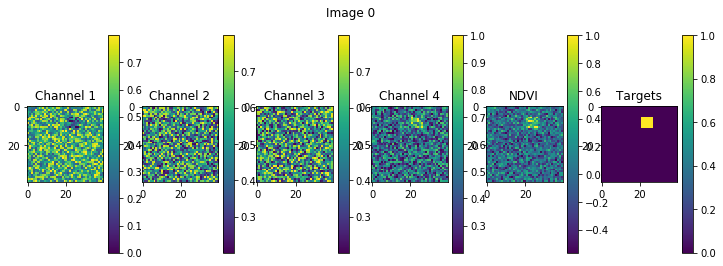

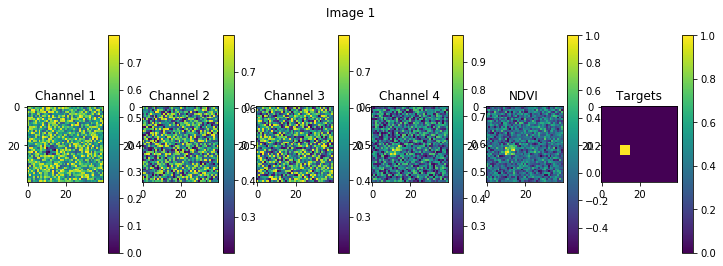

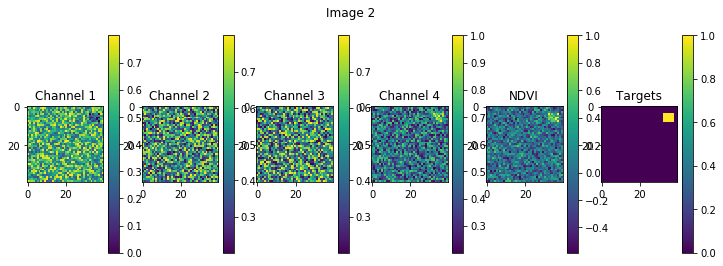

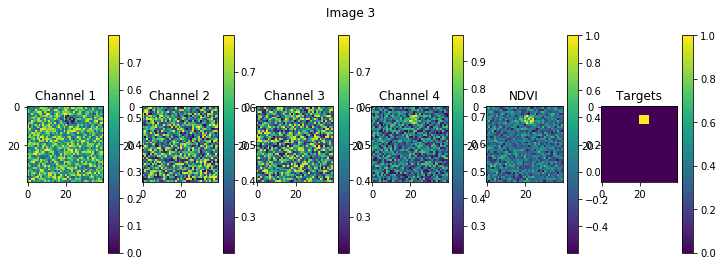

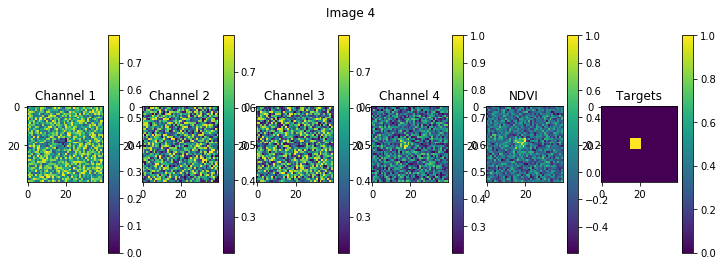

In [60]:
for j in range(5):
    print("Object : {}".format(objects[j]))
    plt.figure(figsize=(12,4))
    plt.suptitle("Image %i" % j)
    for i in range(inputs.shape[1]):
        plt.subplot(1,6,i+1)
        plt.imshow(inputs[j,i,:,:], interpolation='none')
        plt.colorbar()
        plt.title("Channel %s" % str(i+1))
    ndvi = (inputs[j,3,:,:] - inputs[j,0,:,:]) / (inputs[j,3,:,:] + inputs[j,0,:,:])
    plt.subplot(1,6,5)
    plt.imshow(ndvi, interpolation='none')
    plt.colorbar()
    plt.title("NDVI")
    plt.subplot(1,6,6)
    plt.imshow(targets[j,0,:,:], interpolation='none')
    plt.colorbar()
    plt.title("Targets")

In [61]:
ll = int(n_images * 0.75)
X_train = inputs[:ll,:,:,:]
X_test  = inputs[ll:,:,:,:]
Y_train = targets[:ll,:,:,:]
Y_test = targets[ll:,:,:,:]
print X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(375L, 4L, 40L, 40L) (125L, 4L, 40L, 40L) (375L, 1L, 40L, 40L) (125L, 1L, 40L, 40L)


## Define an neural network architecture

### Small U-net like network
Let's take a small U-net type network

In [62]:
import theano
from keras.backend import image_dim_ordering
print theano.config.device
print image_dim_ordering()

gpu0
th


In [63]:
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, Input, merge
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [64]:
n_filters_0 = 8
n_classes = 1
n_channels = 4
deep=False

_inputs = Input((n_channels, input_height, input_width))
x = _inputs

x1 = Convolution2D(n_filters_0, 3, 3, border_mode='same', activation='relu')(x)

x = MaxPooling2D()(x1)
x2 = Convolution2D(n_filters_0 * 2, 3, 3, border_mode='same', activation='relu')(x)
# size/2

x = MaxPooling2D()(x2)
x3 = Convolution2D(n_filters_0 * 4, 3, 3, border_mode='same', activation='relu')(x)
# size/4

x = UpSampling2D()(x3)
x = merge([x2, x], mode='concat', concat_axis=1)
x = Convolution2D(n_filters_0 * 2, 3, 3, border_mode='same', activation='relu')(x)
# size/2

x = UpSampling2D()(x)
x = merge([x1, x], mode='concat', concat_axis=1)
x = Convolution2D(n_filters_0, 3, 3, border_mode='same', activation='relu')(x)

x = Convolution2D(n_classes, 1, 1, border_mode='same', activation='sigmoid')(x)

_outputs = x

model = Model(input=_inputs, output=_outputs)

In [65]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 4, 40, 40)     0                                            
____________________________________________________________________________________________________
convolution2d_28 (Convolution2D) (None, 8, 40, 40)     296         input_6[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_11 (MaxPooling2D)   (None, 8, 20, 20)     0           convolution2d_28[0][0]           
____________________________________________________________________________________________________
convolution2d_29 (Convolution2D) (None, 16, 20, 20)    1168        maxpooling2d_11[0][0]            
___________________________________________________________________________________________

In [66]:
model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=['recall', 'precision', 'accuracy'])

In [67]:
batch_size=16
history = model.fit(X_train, Y_train, nb_epoch=100, batch_size=batch_size, validation_data=[X_test, Y_test], shuffle=True, verbose=0)

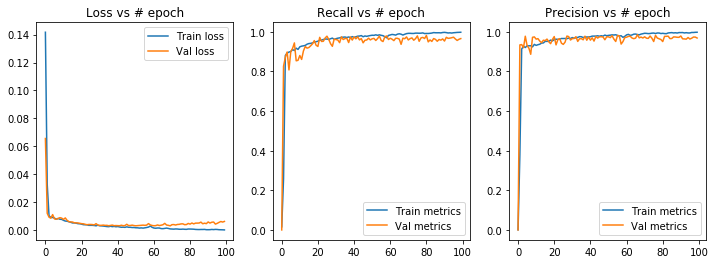

In [68]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Loss vs # epoch")
plt.legend()
plt.subplot(132)
plt.plot(history.history['recall'], label='Train metrics')
plt.plot(history.history['val_recall'], label='Val metrics')
plt.title("Recall vs # epoch")
plt.legend()
plt.subplot(133)
plt.plot(history.history['precision'], label='Train metrics')
plt.plot(history.history['val_precision'], label='Val metrics')
plt.title("Precision vs # epoch")
plt.legend()

In [69]:
Y_pred = model.predict(X_test)
Y_pred.shape, Y_pred.min(), Y_pred.max()

((125L, 1L, 40L, 40L), 0.0, 1.0)

In [70]:
from sklearn.metrics import mean_absolute_error

y_test = Y_test.reshape((Y_test.shape[0], np.prod(Y_test.shape[1:])))
y_true = Y_pred.reshape((Y_pred.shape[0], np.prod(Y_pred.shape[1:])))

mean_absolute_error(y_true, y_test)

0.0013045472

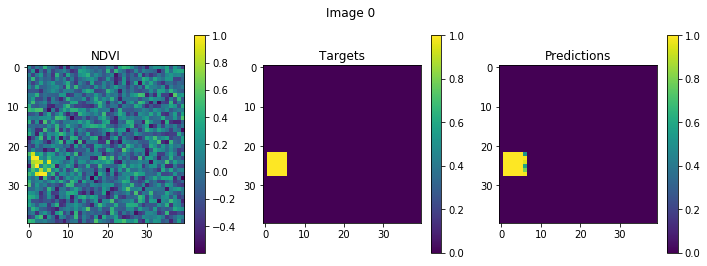

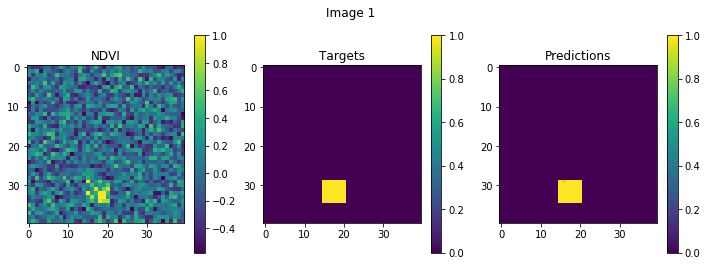

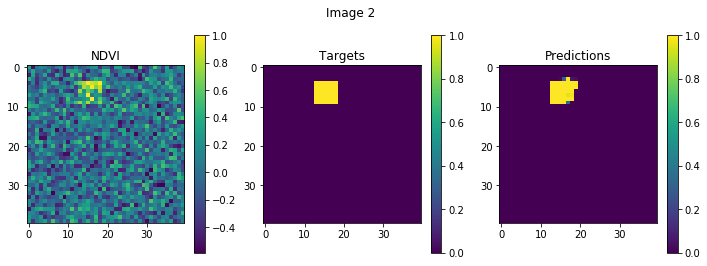

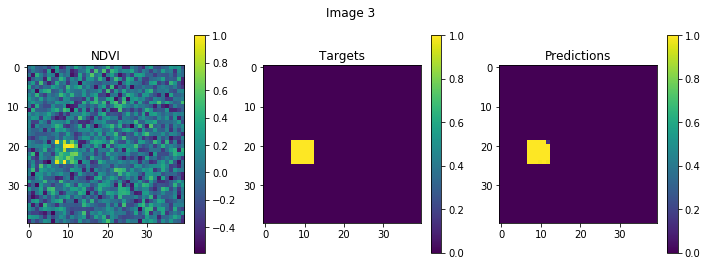

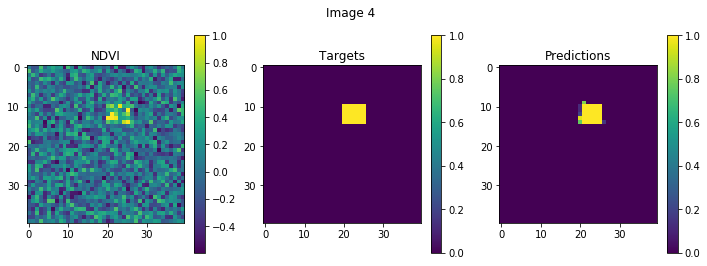

In [71]:
for j in range(5):
    plt.figure(figsize=(12,4))
    plt.suptitle("Image %i" % j)
    plt.subplot(131)
    ndvi = (X_test[j,3,:,:] - X_test[j,0,:,:]) / (X_test[j,3,:,:] + X_test[j,0,:,:])
    plt.imshow(ndvi, interpolation='none')
    plt.colorbar()
    plt.title("NDVI")
    plt.subplot(132)
    plt.imshow(Y_test[j,0,:,:], interpolation='none')
    plt.colorbar()
    plt.title("Targets")
    plt.subplot(133)
    plt.imshow(Y_pred[j,0,:,:], interpolation='none')
    plt.colorbar()
    plt.title("Predictions")

## Look inside the network

Let's take a look on feature maps created by the trained network

In [72]:
import keras.backend as K

def get_layer_output_f(layer_name, model):
    inputs = [K.learning_phase()] + model.inputs
    output_layer = model.get_layer(name=layer_name)
    outputs = output_layer.output
    return K.function(inputs, [outputs])
    
def compute_layer_output(input_data, layer_output_f):
    return layer_output_f([0] + [input_data])

def compute_layer_outputs(input_data, model, layer_output_f_dict={}):
    layer_outputs = []
    for layer in model.layers:
        if layer in model.input_layers or layer in model.output_layers:
            continue
        print layer.name
        if layer.name not in layer_output_f_dict:
            layer_output_f_dict[layer.name] = get_layer_output_f(layer.name, model)
        layer_outputs.append((layer.name, compute_layer_output(input_data, layer_output_f_dict[layer.name])))
    return layer_outputs

def display_layer_output(layer_name, layer_output, **kwargs):
    
    layer_output = layer_output[0]
    nc = layer_output.shape[1]
    n_cols = 4 
    n_rows = int(np.floor(nc / n_cols))
    plt.suptitle("First output for layer %s : %i - %i" % (layer_name, 1, nc))
    for i in range(nc):
        plt.subplot(n_rows,n_cols,i+1)
        plt.imshow(layer_output[0,i,:,:], interpolation='none')   
        plt.axis('off')

In [73]:
layer_output_f_dict = {}
layer_outputs = compute_layer_outputs(X_test[:1,:,:,:], model, layer_output_f_dict)

convolution2d_28
maxpooling2d_11
convolution2d_29
maxpooling2d_12
convolution2d_30
upsampling2d_10
merge_10
convolution2d_31
upsampling2d_11
merge_11
convolution2d_32


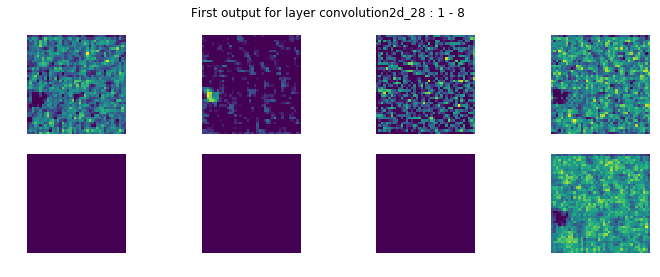

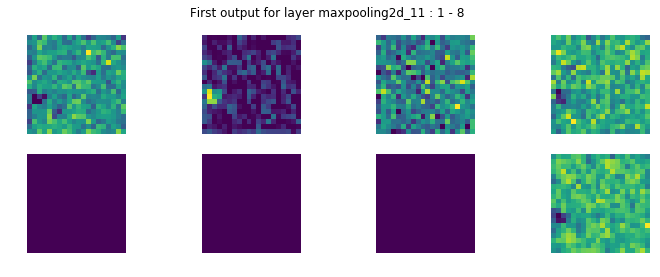

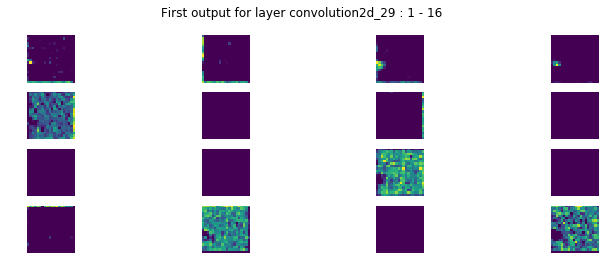

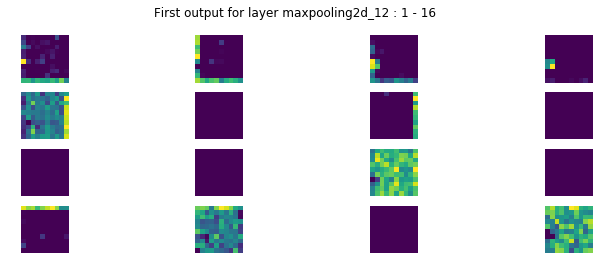

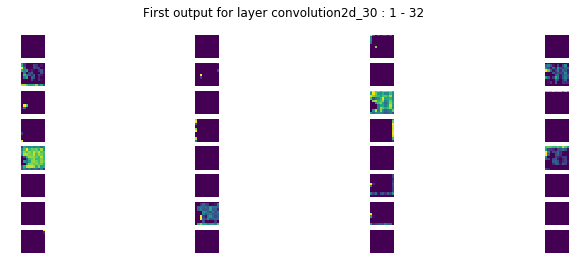

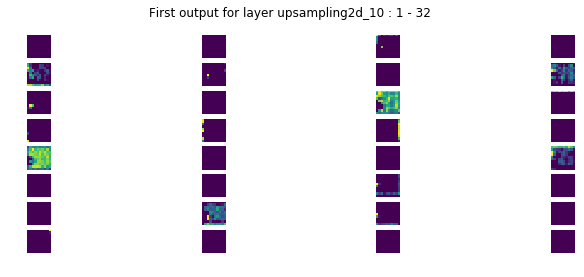

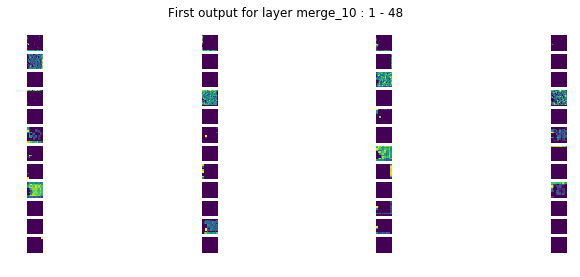

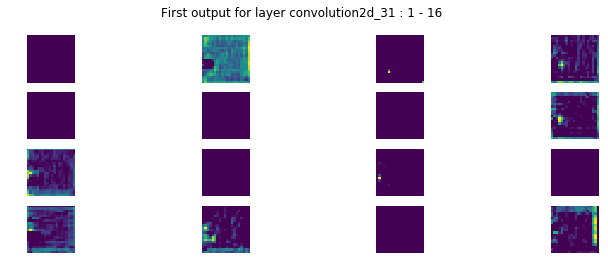

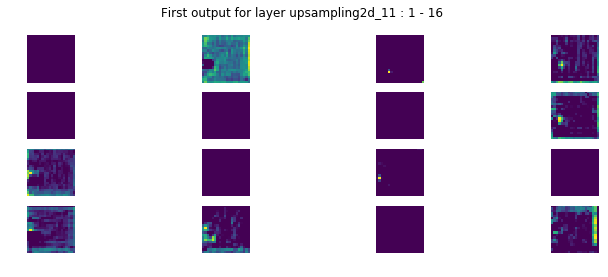

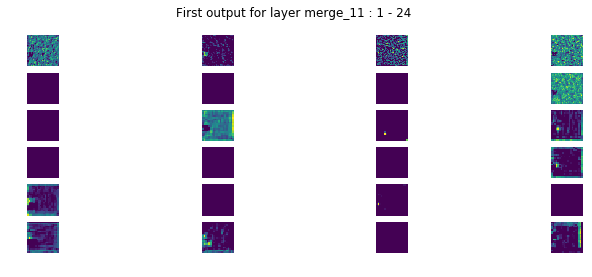

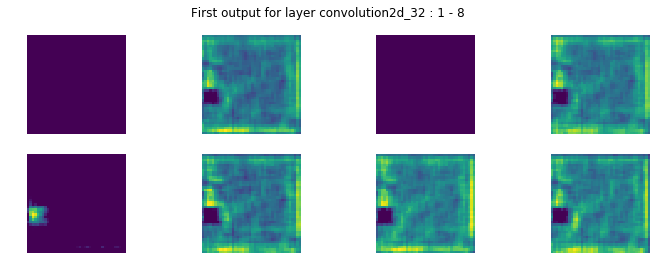

In [74]:
for layer_output in layer_outputs:
    plt.figure(figsize=(12,4))
    display_layer_output(*layer_output)

## Ratio function network architecture

In [ ]:
max_power = 1

x_in = Input((ndim,))

def create_powers(input_layer, max_power, nb_layers=1, n_filters=100):
    # Create `max_power` of combinations [c + w*x_in]
    xs = []
    x = input_layer
    for i in range(max_power):
        for i in range(nb_layers):
            x = Dense(n_filters, activation='relu', init='one')(x)        
        xs.append(x)

    # Merge multiply:
    if len(xs) > 1:
        x = merge([xs[0], xs[1]], mode='mul')
        for i in range(max_power - 2):
            x = merge([x, xs[i+2]], mode='mul')
    else:
        x = xs[0]
    return x

# Create numerator & denominator
x_numerator = create_powers(x_in, max_power, nb_layers=1, n_filters=2)
x_numerator = Dense(1, init='one', name='numerator')(x_numerator)
x_denominator = create_powers(x_in, max_power, nb_layers=1, n_filters=2)
x_denominator = Dense(1, init='one', name='denominator')(x_denominator)
    
# Divide
def division(list_of_tensors): 
    return list_of_tensors[0] / (list_of_tensors[1] + K.epsilon())

x = merge([x_numerator, x_denominator], mode=division, output_shape=x_numerator._keras_shape[1:], name='fraction')
x_out = x

model = Model(input=x_in, output=x_out)